# Image Segmentation: Unet on Nuclei, etc.

## Section 1.Imports & Mount Drive

In [0]:
%gui qt5
import sys
sys.path.append('/content/drive/My Drive/Segmentation/CellSegmentation/')
# import napari
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Section 2.Data Processing (Generate HDF5)

**Purpose:** This Section is used to convert original data into HDF5 format, in order to feed into Neural Networks.

**Notice 1: If you have already got the hdf5 files like 'data.hdf5, data_360.hdf5' from somewhear, then you can skip this section.** 

**Notice 2:** Maybe you want to unzip .zip files locally. Colab & Drive has bugs dealing with large files or large quantity of files (>1000 files in one directory)

In [0]:
# Preperation for downloading from Kaggle

!pip install -U kaggle --quiet
!mkdir -p ~/.kaggle # copy kaggle.json to Google Drive change access mode
!cp /content/drive/My\ Drive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# Download HPA Dataset
!kaggle competitions download -c human-protein-atlas-image-classification

In [0]:
# unzip .zip files

from zipfile import ZipFile
file_name = "/content/drive/My Drive/Segmentation/HPADataset/train.csv.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall(path="/content/drive/My Drive/Segmentation/HPADataset/train_dataset/")
  print("done")

In [0]:
# can't unzip because of too many image files

from zipfile import ZipFile
file_name = "/content/drive/My Drive/Segmentation/HPADataset/train_dataset/human-protein-atlas-image-classification.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall(path="/content/drive/My Drive/Segmentation/HPADataset/train_unzip/")
  print("done")

In [0]:
# Create .hdf5 file for nuclei dataset
!python /content/drive/My\ Drive/Segmentation/CellSegmentation/process_data/nuclei_create_hdf5.py --input_dir "/content/drive/My Drive/Segmentation/NucleiDataset/stage1_train/"  --output_dir "/content/drive/My Drive/Segmentation/NucleiDataset/stage1_train_HDF5/"

In [0]:
# Create .hdf5 file for hpa dataset
!python /content/drive/My\ Drive/Segmentation/CellSegmentation/process_data/hpa_create_hdf5.py --input_dir "/content/drive/My Drive/Segmentation/HPADataset/train_dataset"  --output_dir "/content/drive/My Drive/Segmentation/HPA_HDF5/"

## Section 3. Model Training ---- UNet/DialationCNN/FusionNet

In [0]:
# You must run it before training: required in training process
!pip install tensorboardX==1.4

In [0]:
# UNet/Fusion/DialationCNN On **Nuclei Dataset**
# change the argument '--model unet' as your like
# you might want to change '--epoch num' for better training
!python /content/drive/My\ Drive/Segmentation/CellSegmentation/train.py --num_kernel 16\
                --kernel_size 3\
                --lr 1e-3 \
                --train_data /content/drive/My\ Drive/Segmentation/NucleiDataset/stage1_train_HDF5/data_360.hdf5 \
                --save_dir /content/drive/My\ Drive/Segmentation \
                --device cuda\
                --dataset nuclei\
                --target_channels 4 \
                --optimizer adam\
                --model dilation\
                --shuffle False \
                --num_workers 16 \
                --batch_size 16 \
                --epoch 150 \
                --gpu_ids 0\
                --experiment_name dilation_nuclei_16_epoch150

In [0]:
# UNet/Fusion/DialationCNN On **HPA Dataset**
# HDF5 file 'data.hdf5' is so large(30GB) that google drive has problems loading it...
# So this script is always stuck at loading process...
# error: unable to open file 'data.hdf5';[Colab has problem open large files]
!python  /content/drive/My\ Drive/Segmentation/CellSegmentation/train.py --num_kernel 8 \
                --kernel_size 3\
                --lr 1e-3 \
                --epoch 200\
                --train_data /content/drive/My\ Drive/Segmentation/HPADataset/hpa_train/data.hdf5 \
                --save_dir /content/drive/My\ Drive/Segmentation \
                --device cuda\
                --dataset hpa\
                --optimizer adam\
                --model unet\
                --shuffle False \
                --max_mean max \
                --target_channels '0,2,3' \
                --num_workers 32 \
                --batch_size 8 \
                --gpu_ids 0\
                --transform True\
                --experiment_name hpa_1c_max_16

In [0]:
# **No Use** (Not implemented)
# UNet/Fusion/DialationCNN On **Neuro Dataset**
!python train.py --num_kernel 8 \
                --kernel_size 3\
                --lr 1e-3 \
                --epoch 100 \
                --train_data PATH_TO_TRAIN_DATA \
                --save_dir ./ \
                --dataset neuro \
                --device cuda\
                --optimizer adam\
                --model unet\
                --shuffle False \
                --max_mean max \
                --target_channels '3'\
                --num_workers 32 \
                --batch_size 8 \
                --gpu_ids 0\
                --transform False\
                --experiment_name neuro


## Section 4. Model Testing ---- UNet/DialationCNN/FusionNet

In [0]:
# ------task1: test different "Models" on "Nuclei" dataset------
# Model: UNet/FusionNet/DilatedCNN
# Dataset: Nuclei train_stage1
# -------------------Change Dataset: Using different ".hdf5" file-------------------
# --test_dataset /content/drive/My\ Drive/Segmentation/NucleiDataset/stage1_train_HDF5/data_360.hdf5 \
# --dataset nuclei\
# "data_360.hdf5" is the Nuclei dataset's name
# -------------------Change Model: Using different saved model dict.-------------------
# --load_model_dict /content/drive/My\ Drive/Segmentation/UNet_nuclei_1c_16.pth \
# --model unet\
# -----------------------------------------------------------------------------------------------
!python3 /content/drive/My\ Drive/Segmentation/CellSegmentation/test_models_nuclei.py --num_kernel 16\
                --kernel_size 3\
                --lr 1e-3 \
                --epoch 1\
                --test_dataset /content/drive/My\ Drive/Segmentation/NucleiDataset/stage1_train_HDF5/data_360.hdf5 \
                --dataset nuclei\
                --load_model_dict /content/drive/My\ Drive/Segmentation/UNet_nuclei_1c_16.pth \
                --model unet\
                --save_dir /content/drive/My\ Drive/Segmentation \
                --device cuda\
                --target_channels 4 \
                --optimizer adam\
                --shuffle False \
                --num_workers 16 \
                --batch_size 32 \
                --epoch 150 \
                --gpu_ids 0\
                --experiment_name unet_nuclei_16_ex2

---------Finish get dataset---------
---------Finish create dataloader---------
---------Finish create model---------
---------Finish move to cuda---------
---------Finish optimizer & loss---------
---------Finish load model---------
Start the loop!
/content/drive/My Drive/Segmentation/CellSegmentation/test_models_nuclei.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x_test, requires_grad=False, device='cuda', dtype=torch.float32)
/content/drive/My Drive/Segmentation/CellSegmentation/test_models_nuclei.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y_test, requires_grad=False, device='cuda')
Batch 0 , Obtained an ious of [0.8795767551226067

## Section 5. Application 1--- Generate Augmented PNG images --- Pap Smear Datasets

In [0]:
# -----Task: Generating Augmented Dataset-----
# model: Unet
# dataset: pap smear
# Not fully implemented yet
!python3 /content/drive/My\ Drive/Segmentation/CellSegmentation/apply_papsmear_UNet.py --num_kernel 16\
                --kernel_size 3\
                --lr 1e-3 \
                --epoch 1\
                --save_dir /content/drive/My\ Drive/Segmentation \
                --device cuda\
                --optimizer adam\
                --model unet\
                --shuffle False \
                --num_workers 16 \
                --batch_size 32 \
                --epoch 200 \
                --gpu_ids 0\
                --experiment_name unet_nuclei_16_ex3

In [0]:
import PIL.Image as Image
import torch
from dataset import NucleiDataset, HPADataset, NeuroDataset, HPASingleDataset,get_augmenter
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 16

def thresholdImg(img, threshold):
    img[img>threshold] = 2**8-1;
    img[img<=threshold] = 0;
    return img

# step1: load the saved tensor .ph
print('Start: step1')
predictions = torch.load('NeucleiMaskTensor.pt')
for pred in predictions:
    for tensor in pred:
        tensor_ex = tensor.cpu().numpy()

# step2: load the original dataset
print('Start: step2')
test_dataset_path = '/content/drive/My Drive/Segmentation/NucleiDataset/stage1_train_HDF5/data_360.hdf5'
test_dataset = NucleiDataset(test_dataset_path, 'train', transform=False, target_channels="4")
# create dataloader
test_params = {'batch_size': BATCH_SIZE,
                'shuffle': False,
                'num_workers': NUM_WORKERS}
test_dataloader = DataLoader(test_dataset, **test_params)
print('finish: create DataLoader')
for i, (x_test, y_test) in enumerate(test_dataloader):
    x = torch.tensor(x_test, requires_grad=False, device='cuda', dtype=torch.float32)
    y = torch.tensor(y_test, requires_grad=False, device='cuda')         
    # tensor --> numpy.array
    x = x.cpu().numpy()
    x = (x[-1]*256-1).astype(np.int32).reshape( x.shape[2], x.shape[3] )
    # numpy.array --> Image
    img = Image.fromarray(x)
    img = img.convert("L")
    img.show()
    img.save('dataset_example'+ str(i) +'.png')

# step3: apply mask and write
print('Start: step3')
tensor_ex = thresholdImg(tensor_ex, 0.5)
# tensor --> numpy.array
tensor_ex = tensor_ex.astype(np.int32).reshape( tensor_ex.shape[1], tensor_ex.shape[2] )
# numpy.array --> Image
img = Image.fromarray(tensor_ex)
img = img.convert("L")
img.show()
img.save('gradient1.png')

In [0]:
import PIL.Image as Image
import torch
import pickle
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as pyplot
# ------------------Task2------------------
# step2: load the original dataset
train_x = pickle.load( open( "/content/drive/My Drive/pap_smear/train_x32.p", "rb" ) )
train_x = train_x.cpu().numpy()
ind = -13

train_x = ( (train_x[ind]-train_x[ind].min())/(train_x[ind].max()-train_x[ind].min()) * 255 ).astype(np.int32).reshape( train_x.shape[1], train_x.shape[2], train_x.shape[3] )
r=Image.fromarray(train_x[0]).convert('L')
g=Image.fromarray(train_x[1]).convert('L')
b=Image.fromarray(train_x[2]).convert('L')
###merge the three channels###
img = Image.merge("RGB", (r, g, b))
###show image####
pyplot.imshow(img)
pyplot.show()

In [0]:
#-----------------------Data Augmentation generation------------------------
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.ndimage import rotate
torch.manual_seed(0) # fixed random seed for reproducibility
np.random.seed(0) # fixed random seed for reproducibility

#----------------------- Image Crop -----------------------
def Image_crop(img, center, crop_size=(10, 10)):
    assert crop_size[0] <= img.shape[0] and crop_size[1] <= img.shape[1], "Crop size should be less than image size"
    img = img.copy()
    w, h = img.shape[:2]
    left, right, down, up = center[0]-crop_size[0]/2, center[0]+crop_size[0]/2, center[1]-crop_size[1]/2, center[1]+crop_size[1]/2
    img = img[down:up, left:right]
    return img


## Section 6. Application 2 --- Overlapping Cervical Cytology Segmentation Challenge (ISBI 2015)

In [0]:
# -----Task: ISBI Segmentation-----
# model: unet/fusion/dialation (change the argument 'model' and 'load_model' as your like)
# dataset: Overlapping Cervical Cytology Image Segmentation Challenge
# --imgdata /content/drive/My\ Drive/Segmentation/OverlappingCervicalImage/Training_R2_Jan2015/frame017_stack/fov010.png \

!python3 /content/drive/My\ Drive/Segmentation/CellSegmentation/apply_isbi_UNet.py --num_kernel 16\
                --kernel_size 3\
                --lr 1e-3 \
                --epoch 1\
                --imgdata /content/drive/My\ Drive/Segmentation/OverlappingCervicalImage/Training_R2_Jan2015/frame007_stack/fov010.png \
                --load_model /content/drive/My\ Drive/Segmentation/FusionNet_nuclei_1c_16.pth \
                --save_dir /content/drive/My\ Drive/Segmentation/OverlappingCervicalImage/ \
                --device cuda\
                --optimizer adam\
                --model fusion\
                --shuffle False \
                --num_workers 16 \
                --batch_size 32 \
                --epoch 200 \
                --gpu_ids 0\
                --experiment_name unet_ISBI_ex1

tensor([[[0.9255, 0.9451, 0.9216,  ..., 0.9529, 0.9529, 0.9529],
         [0.9255, 0.9333, 0.9255,  ..., 0.9647, 0.9608, 0.9686],
         [0.9059, 0.9333, 0.9451,  ..., 0.9608, 0.9569, 0.9608],
         ...,
         [0.7333, 0.7137, 0.7647,  ..., 0.9373, 0.9412, 0.9333],
         [0.7412, 0.7255, 0.7333,  ..., 0.9451, 0.9294, 0.9333],
         [0.7255, 0.7333, 0.7451,  ..., 0.9216, 0.9333, 0.9294]]])
---------Finish loading dataset---------
---------Finish creating model---------
---------Finish move to cuda---------
---------Finish loading model---------
---------Finish optimizer & loss---------
Start the predicting!
/content/drive/My Drive/Segmentation/CellSegmentation/apply_isbi_UNet.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x_test, requires_grad=False, device='cuda', dtype=torch.float32)
/usr/local/lib

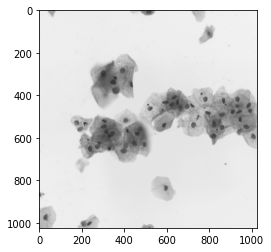

tensor([[[0.9283, 0.9915, 0.9979,  ..., 0.9999, 0.9996, 0.9896],
         [0.9951, 0.9999, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9986, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9976, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9966, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9733, 0.9992, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]])
tensor([[[0.9283, 0.9915, 0.9979,  ..., 0.9999, 0.9996, 0.9896],
         [0.9951, 0.9999, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9986, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9976, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9966, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9733, 0.9992, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]])


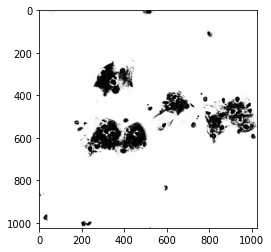

In [0]:
# ------------Show tensor as Image------------
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import PIL
def loadImage(ImgPATH):
    # step1: construct transformation
    img = PIL.Image.open(ImgPATH)
    trans1 = transforms.ToTensor()
    trans2 = transforms.ToPILImage()
    
    # step2: get imgTensor
    imgTensor = trans1(img)

    # step3: show the original image
    imgPIL = trans2(imgTensor).convert("RGB")
    plt.imshow(imgPIL)
    plt.show()

    return imgTensor.unsqueeze(0)

def tesorToImage(in_tensor):
    trans = transforms.ToPILImage()
    imgPIL = trans(in_tensor).convert("RGB")
    ###show image####
    plt.imshow(imgPIL)
    plt.show()
    imgPIL.save("/content/drive/My Drive/Overlap_train_007_fusion_epoch50.png","PNG")

ORIGINAL_IMG_PATH = '/content/drive/My Drive/Segmentation/OverlappingCervicalImage/Training_R2_Jan2015/frame007_stack/fov010.png'
TENSOR_PATH = '/content/drive/My Drive/Segmentation/OverlappingCervicalImage/unet_ISBI_ex1.pt'

threshold = 0.5
original_img_tensor = loadImage(ORIGINAL_IMG_PATH)
aug_tensor = torch.load(TENSOR_PATH)
aug_tensor =aug_tensor.squeeze(0).cpu()

# print(aug_tensor)
# aug_tensor[aug_tensor>threshold] = 1
# aug_tensor[aug_tensor<=threshold] = 0
# print(aug_tensor)

tesorToImage(aug_tensor.squeeze(0).cpu())

In [0]:
# Pre-processing: Get white background "raw images"
import cv2
WHITE_IMG_PATH = '/content/drive/My Drive/Segmentation/OverlappingCervicalImage/Training_R2_Jan2015/frame017_stack/fov010.png'
WRITE_PATH = '/content/drive/My Drive/'
temp_img = cv2.imread(WHITE_IMG_PATH, 0)
print(temp_img)
for i in range(len(temp_img)):
  for j in range(len(temp_img[0])):
    if temp_img[i][j] > 220:
      temp_img[i][j] = 255
from google.colab.patches import cv2_imshow
cv2.imwrite(WRITE_PATH+'frame017_stack_white.png', temp_img)

## Section INF. Debug Tools

In [0]:
# Debug: test HDF5 file
import h5py
import numpy as np
# Open Files
f = h5py.File('/content/drive/My Drive/Segmentation/HPADataset/hpa_train/data.hdf5', 'r')
data_set = f['media/shimin/LENOVO/GoogleDriveSync/hpa_train/train']
# type(data_set)
# print(data_set)
for item in data_set:
    print(item)

In [0]:
!/opt/bin/nvidia-smi

/bin/bash: /opt/bin/nvidia-smi: No such file or directory


In [0]:
pretrained_dict = torch.load('/content/drive/My Drive/Segmentation/UNet_nuclei_1c_16.pth')
# 1. filter out unnecessary keys

for key in pretrained_dict['model_state'].keys():
    print('key = {}'.format(key))

In [0]:
# Analyse HDF5 files
import h5py
import numpy as np

with h5py.File('/content/drive/My Drive/Segmentation/HPADataset/hpa_train/data.hdf5', 'r') as f:
    f.keys()

In [0]:
f['media/shimin/LENOVO/GoogleDriveSync/hpa_train/train']['000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0']